# supernode-edges

The procedure of constructing weighted L-space and P-space edges of the supernode network.

__Warning!__ Some procedures require 16 cores and up to 10 GB RAM.

Requires:
1. `data/preprocessed/routes.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/edges_lspace.json`
2. `data/supernodes/edges_pspace_alpha_metrics.json`
3. `data/supernodes/edges_pspace.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List, Dict
from multiprocessing import Pool
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
from matplotlib import pyplot as plt

from myutils.networkx import get_layout
from myutils.spatial import get_earth_distances
from myutils.json import save_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from ptn.parallel_centralities import shortest_paths_parallel
from config import routes_fpath, supernodes_fpath, edges_lspace_fpath, \
    edges_pspace_alpha_metrics_fpath, edges_pspace_fpath

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
routes = pd.read_json(routes_fpath).set_index('id')

routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [4]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


### L-space

### P-space

In [5]:
coords = supernodes[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    return distances[route[:-1], route[1:]].sum()

In [6]:
def construct_pspace_edges(alpha: float) -> List[Dict[str, float]]:
    edges = []

    for _, route in routes['supernodes'].iteritems():
        n = len(route)

        for i in range(n - 1):
            for j in range(i + 1, n):
                u = route[i]
                v = route[j]

                if u > v:
                    u, v = v, u

                subroute = route[i : j + 1]
                
                distance = get_route_distance(subroute)
                weight = 1 - alpha + alpha * distance

                edges.append((u, v, distance, weight))

    edges = pd.DataFrame(edges, columns=['u', 'v', 'distance', 'w'])\
        .sort_values(by=['u', 'v', 'w']).drop_duplicates(['u', 'v'], keep='first')

    edges = [
        {
            'u': int(row['u']),
            'v': int(row['v']),
            'w': float(row['w']),
            'distance': float(row['distance']),
        }
        for _, row in edges.iterrows()
    ]
    
    return edges

In [7]:
metrics = pd.read_json(edges_pspace_alpha_metrics_fpath).set_index('alpha')

metrics.head(2)

,distance_mean,distance_median,distance_q1,distance_q3,distance_max,hops_mean,hops_median,hops_q1,hops_q3,hops_max
alpha,,,,,,,,,,
0.010,34.603154,29.776188,17.180731,45.820028,200.557199,3.184869,3,3,4,8
0.108,33.726213,28.974031,16.788581,44.650621,200.557199,3.252099,3,3,4,8


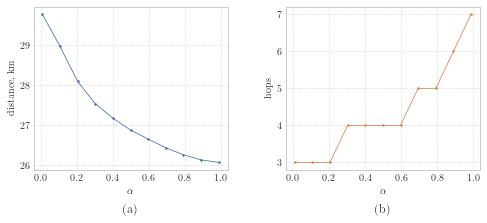

In [8]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 3)
fig.subplots_adjust(wspace=0.3)

for i, metric, ax in zip(range(2), ['distance', 'hops'], axes):
    color = f'C{i}'
    
    # ax.plot(metrics[f'{metric}_mean'], c=color, lw=0.8, marker='.', markersize=3)
#     ax.fill_between(
#         metrics.index,
#         metrics[f'{metric}_t1'],
#         metrics[f'{metric}_t2'],
#         color=color,
#         alpha=0.15,
#     )
    
    ax.plot(metrics[f'{metric}_median'], c=color, lw=0.8, marker='.', markersize=3)
    
    # ax.set_title(metric)
    ax.set_xlabel('$\\alpha$')
    
axes[0].set_ylabel('distance, km')
axes[0].set_title('(a)', y=-0.3)
axes[1].set_ylabel('hops')
axes[1].set_title('(b)', y=-0.3)

plt.savefig('../figures/weight_alpha_metrics.pdf', transparent=True, bbox_inches='tight')

In [9]:
edges = construct_pspace_edges(alpha=0.33)

edges[:5]

[{'u': 0, 'v': 6, 'w': 8.349711464586662, 'distance': 23.271852922989886},
 {'u': 0, 'v': 8, 'w': 5.571580885524599, 'distance': 14.853275410680604},
 {'u': 0, 'v': 9, 'w': 5.285174979311074, 'distance': 13.985378725185072},
 {'u': 0, 'v': 13, 'w': 4.273017234500154, 'distance': 10.918234043939858},
 {'u': 0, 'v': 14, 'w': 4.8279504115066505, 'distance': 12.599849731838335}]

In [10]:
weighted_edges = [(edge['u'], edge['v'], edge['w']) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3202, 118449)

In [11]:
pos = dict(zip(supernodes.index, supernodes[['lon', 'lat']].values))

In [12]:
components = sorted(nx.connected_components(g.to_undirected()), key=len, reverse=True)

node_size = {node: 0.25 if i == 0 else 2 for i, comp in enumerate(components) for node in comp}
node_size = [node_size[node] for node in g]

node_color = {node: f'C{i}' for i, comp in enumerate(components) for node in comp}
node_color = [node_color[node] for node in g]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


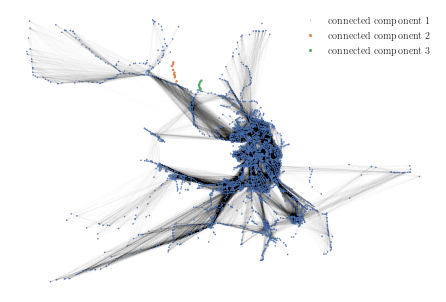

In [13]:
plt.figure(figsize=(6, 4))

nx.draw(g, pos, node_size=node_size, width=0.003, node_color=node_color)

handles = []
labels = []

for i, comp in enumerate(components):
    size = 0.25 if i == 0 else 2
    
    labels.append(f'connected component {i + 1}')
    handles.append(plt.Line2D([0], [0], color=f'C{i}', linewidth=0, marker='o', markersize=size))

plt.legend(handles=handles, labels=labels, loc='upper right')
    
plt.savefig('../figures/pspace_edges.png', dpi=250, transparent=True, bbox_inches='tight')

In [14]:
save_json(edges, edges_pspace_fpath)